In [2]:
from mmcv import Config
import sys
sys.path.append("../")
from mmdet.models.builder import build_detector
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
# 模型的加载
# load model
cfg = Config.fromfile('../configs/loft_foa_prompt/loft_foa_r50_fpn_2x_bonai_prompt.py')
model = build_detector(cfg.model, test_cfg=cfg.test_cfg)
load_checkpoint(model, '/config_data/work_dirs/loft_foa_r50_fpn_2x_bonai/epoch_24.pth', map_location='cpu')
model.eval()




/root/miniconda3/envs/mmdet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/mmdet/lib/python3.8/site-packages/mmcv/utils/registry.py:63: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  warnings.warn(
2023-09-22 07:08:49,124 - mmdet - INFO - load model from: torchvision://resnet50
2023-09-22 07:08:49,344 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



prompt_LOFT(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [3]:
# 数据加载
# load data
import torchvision.transforms as T
from pycocotools.coco import COCO

normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transforms = T.Compose([
            T.Resize(1024),

            T.ToTensor(),
            normalize,
        ])
test_set = COCO('/data/BONAI_data/BONAI-20230403T091731Z-002/BONAI/coco/bonai_shanghai_xian_test.json')


loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


torch.Size([1, 3, 1024, 1024])


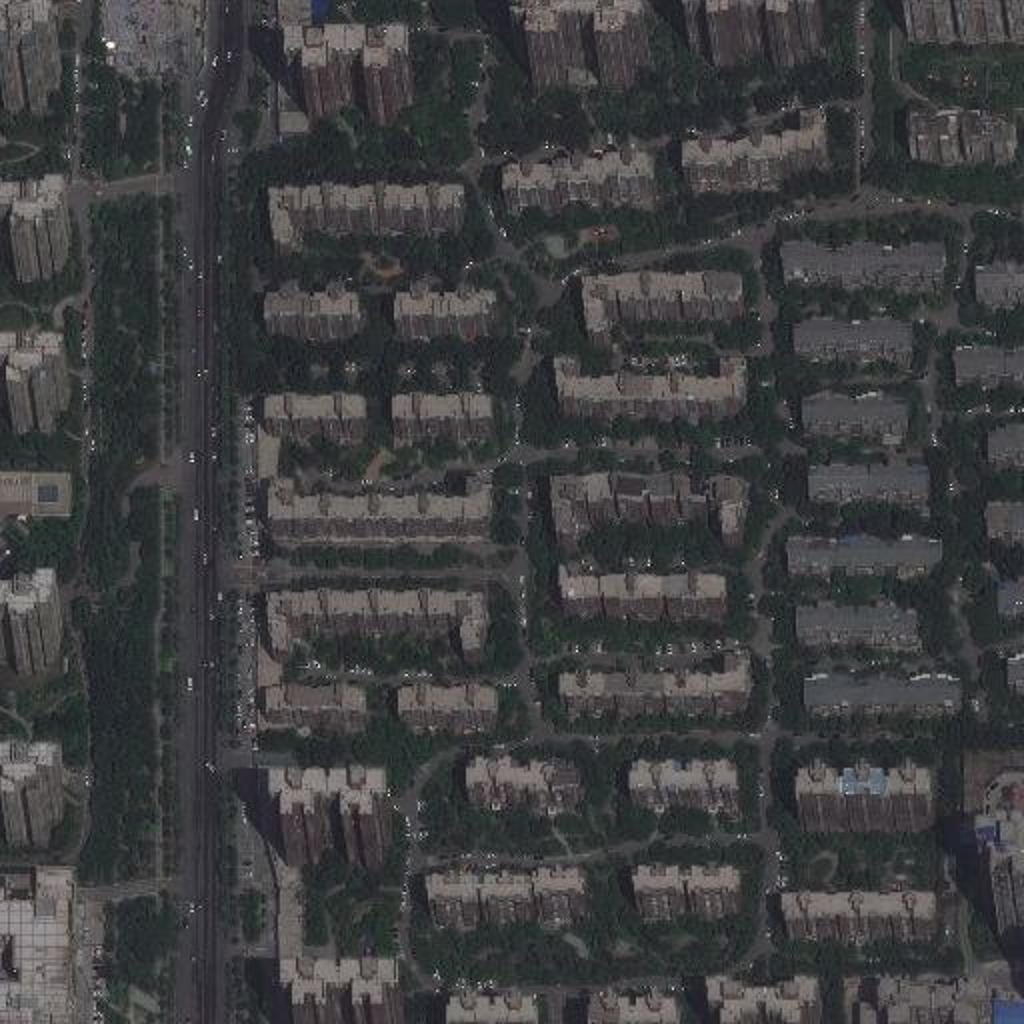

In [4]:
# get a single image
from PIL import Image
imset = test_set.getImgIds()
img = test_set.loadImgs(test_set.getImgIds()[7])[0]

image = Image.open('/data/BONAI_data/BONAI-20230403T091731Z-002/BONAI/test/test/'+img['file_name'])
bbox  = test_set.loadAnns(test_set.getAnnIds(imgIds=img['id']))
bbox = [i['building_bbox'] for i in bbox]
input_tensor = transforms(image).unsqueeze(0)
print(input_tensor.shape)
image


In [5]:
import random
# import os
import seaborn as sns

def random_num(size,end):
    range_ls=[i for i in range(end)]
    num_ls=[]
    for i in range(size):
        num=random.choice(range_ls)
        range_ls.remove(num)
        num_ls.append(num)
    return num_ls
# get feature maps
features = model.backbone(input_tensor)
print([n.shape for n in features])

f0 = features[0]

# 区间每8个特征层求均值
# f0 = f0.mean(dim=1, keepdim=True)
# print(f0)

from matplotlib import pyplot as plt
import cv2
import os.path as osp
folder = '/config_data/BONAI_data/BONAI-20230403T091731Z-002/BONAI/featuremaps/'
v = f0.data.squeeze(0)
v = v.permute(1, 2, 0)
#随机选取25个通道的特征图
channel_num = random_num(25,256)
plt.figure(figsize=(10, 10))
for channel in range(250):
    # ax = plt.subplot(5, 5, index+1,)
    # plt.imshow(v[:, :, channel:channel+3])
    cv2.imwrite(osp.join(folder, f'{channel}.jpg'), (255*v[:, :,channel:channel+3]/v[:, :,channel:channel+3].max()).numpy().astype('uint8'))

[torch.Size([1, 256, 256, 256]), torch.Size([1, 512, 128, 128]), torch.Size([1, 1024, 64, 64]), torch.Size([1, 2048, 32, 32])]


<Figure size 1000x1000 with 0 Axes>

In [32]:
# ROI pooling
import torch
import numpy as np

def xyxy2xywh(rois):
    rois[:,2] = rois[:,2]-rois[:,0]
    rois[:,3] = rois[:,3]-rois[:,1]
    return rois

bbox = np.array(bbox)
rois = xyxy2xywh(bbox)
gt_bboxes = []
for b in rois:
    z = np.zeros(5)
    z[1:]=b
    gt_bboxes.append(z)
rois = torch.tensor(gt_bboxes)

offset_feats = model.roi_head.offset_roi_extractor(
                features[:model.roi_head.offset_roi_extractor.num_inputs], rois.float())
# gt_bboxes


RuntimeError: roi_width >= 0 && roi_height >= 0 INTERNAL ASSERT FAILED at "/tmp/pip-install-hacsuc2x/mmcv-full_c96343c169c04a8bbffa2472bdbb15a7/mmcv/ops/csrc/pytorch/roi_align_cpu.cpp":137, please report a bug to PyTorch. ROIs in ROIAlign cannot have non-negative size!